In [1]:
import pandas as pd 
import numpy as np 


import os 
import sys
sys.path.insert(0, os.path.join(os.path.dirname("test_pipeline.ipynb"), '..'))

from src.inference.predictor import (
    Predictor, 
    load_single_model, 
    load_models_from_dir,
)

/home/ib/CSIRO-Image2BiomassPrediction/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FOLD = 0 

TRAIN_CKPT_PATH = "../checkpoints/two_stream_timm/vit_base_patch14_dinov2.lvd142m_our_split"
MODEL_NAME = F"best_model_fold{FOLD}.ckpt"
MODEL_PATH = os.path.join(TRAIN_CKPT_PATH, MODEL_NAME)

DATA_PATH = "../data/csiro-biomass/folds/fold_assignments.csv"

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,image_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g,Sampling_Date_parsed,fold
0,ID1011485656,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750,2015-09-04,2
1,ID1012260530,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000,2015-04-01,1
2,ID1025234388,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500,2015-09-01,2
3,ID1028611175,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376,2015-05-18,1
4,ID1035947949,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605,2015-09-11,4


In [4]:
train_fold = df[df["fold"] != FOLD]
val_fold = df[df["fold"] == FOLD]

print(f"Train fold: {train_fold.shape}")
print(f"Val fold: {val_fold.shape}")

Train fold: (283, 14)
Val fold: (74, 14)


In [5]:
from omegaconf import OmegaConf
from hydra import compose, initialize

cfg = OmegaConf.load("../configs/config.yaml")

with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="config")

# Load trained ckpt

In [6]:
from src.models.two_stream import build_model, get_stream_mode

def model_fn():
    grid = tuple(cfg.model.tiled.grid) if "tiled" in cfg.model.model_type else None
    return build_model(
        model_type=cfg.model.model_type,
        backbone_name=cfg.model.backbone.name,
        pretrained=False,  # We load from checkpoint
        dropout=cfg.model.heads.dropout,
        hidden_ratio=cfg.model.heads.hidden_ratio,
        grid=grid,
    )

In [7]:
import torch

def model_fn():
    grid = tuple(cfg.model.tiled.grid) if "tiled" in cfg.model.model_type else None
    return build_model(
        model_type=cfg.model.model_type,
        backbone_name=cfg.model.backbone.name,
        pretrained=False,  # We load from checkpoint
        dropout=cfg.model.heads.dropout,
        hidden_ratio=cfg.model.heads.hidden_ratio,
        grid=grid,
    )

model = model_fn()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model_fold = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
model_fold


{'epoch': 19,
 'global_step': 720,
 'pytorch-lightning_version': '2.6.0',
 'state_dict': OrderedDict([('model.backbone.cls_token',
               tensor([[[-6.9142e-04, -2.0539e-04, -4.6968e-02, -1.4960e-03, -2.0410e-02,
                          4.7294e-03,  2.6455e-03, -4.9413e-03, -4.9912e-03, -1.1096e-03,
                          2.4690e-03,  7.5610e-03,  7.1985e-03, -3.0513e-04, -3.3493e-03,
                         -3.6020e-04,  1.2004e-02,  1.3525e-03, -1.4590e-02, -8.5887e-03,
                         -7.0904e-04,  2.0706e-04, -1.8931e-03, -1.6581e-03, -1.7453e-03,
                          1.5737e-03, -3.3249e-03, -3.5086e-04,  4.2582e-03, -6.0191e-03,
                         -1.9831e-03,  3.4883e-04, -5.7279e-03,  3.4933e-02,  4.3051e-03,
                          2.9389e-03, -9.7192e-04,  8.2199e-03,  3.6512e-03, -1.9048e-03,
                          2.6950e-03, -4.7313e-02, -1.9887e-02, -7.3382e-04,  7.6832e-03,
                         -2.8708e-02, -1.3646e-03, -1.8689e

In [8]:
model_fold_state_dict = {
    k.replace("model.", "", 1): v
    for k, v in model_fold["state_dict"].items()
    if k.startswith("model.")
}
model_fold_state_dict

{'backbone.cls_token': tensor([[[-6.9142e-04, -2.0539e-04, -4.6968e-02, -1.4960e-03, -2.0410e-02,
            4.7294e-03,  2.6455e-03, -4.9413e-03, -4.9912e-03, -1.1096e-03,
            2.4690e-03,  7.5610e-03,  7.1985e-03, -3.0513e-04, -3.3493e-03,
           -3.6020e-04,  1.2004e-02,  1.3525e-03, -1.4590e-02, -8.5887e-03,
           -7.0904e-04,  2.0706e-04, -1.8931e-03, -1.6581e-03, -1.7453e-03,
            1.5737e-03, -3.3249e-03, -3.5086e-04,  4.2582e-03, -6.0191e-03,
           -1.9831e-03,  3.4883e-04, -5.7279e-03,  3.4933e-02,  4.3051e-03,
            2.9389e-03, -9.7192e-04,  8.2199e-03,  3.6512e-03, -1.9048e-03,
            2.6950e-03, -4.7313e-02, -1.9887e-02, -7.3382e-04,  7.6832e-03,
           -2.8708e-02, -1.3646e-03, -1.8689e-04, -1.7721e-03, -4.0460e-03,
           -3.8712e-04,  8.3599e-03,  1.1057e-03, -2.7552e-03,  1.3896e-02,
           -2.5532e-03,  1.4683e-02, -3.9614e-03,  9.5134e-04,  3.6621e-03,
            3.0747e-04, -2.3839e-03, -1.7077e-03,  2.7554e-03,  2.

In [9]:
model.load_state_dict(model_fold_state_dict, strict=False)
model.to(DEVICE)
model.eval()

TwoStreamMultiHead(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
 

In [10]:
model

TwoStreamMultiHead(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
 

# Predict on train set

In [11]:
# convert wide to long (FIXED)

targets = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

df_long = (
    train_fold.melt(
        id_vars=[c for c in train_fold.columns if c not in targets],
        value_vars=targets,
        var_name="target_name",   # <-- FIX: expected by Predictor
        value_name="target",      # <-- numeric value
    )
    .assign(
        sample_id=lambda d: d["image_id"].astype(str) + "__" + d["target_name"]
    )
    .sort_values(["image_id", "target_name"], kind="stable")
    .reset_index(drop=True)
)

# Optional: keep only what submission / inference actually needs
df_long = df_long[[
    "sample_id",
    "image_path",
    "target_name",
    "target",          # keep for train; for test can be NaN
]]
df_long


,sample_id,image_path,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,GDM_g,16.2750
...,...,...,...,...
1410,ID983582017__Dry_Clover_g,train/ID983582017.jpg,Dry_Clover_g,0.0000
1411,ID983582017__Dry_Dead_g,train/ID983582017.jpg,Dry_Dead_g,0.0000
1412,ID983582017__Dry_Green_g,train/ID983582017.jpg,Dry_Green_g,40.9400
1413,ID983582017__Dry_Total_g,train/ID983582017.jpg,Dry_Total_g,40.9400


In [12]:
cfg.inference

{'batch_size': 4, 'num_workers': 4, 'use_amp': True, 'use_tta': True, 'tta_views': ['original', 'hflip', 'vflip'], 'checkpoint_path': None, 'checkpoint_dir': '${checkpoint_dir}', 'checkpoint_pattern': '*.ckpt', 'submission_file': 'submission.csv'}

In [13]:
cfg.data.test_image_dir = '/home/ib/CSIRO-Image2BiomassPrediction/data/csiro-biomass/train'

In [14]:
# Load test data
print(f"\n[2/4] Loading test data...")
test_long_df = df_long
test_unique_df = train_fold
print(f"✓ Found {len(test_unique_df)} unique test images")

models = [model]
stream_mode = get_stream_mode(cfg.model.model_type)
device = DEVICE

# Create predictor
predictor = Predictor(
    models=models,
    stream_mode=stream_mode,
    device=device,
    use_amp=cfg.inference.use_amp,
    use_tta=cfg.inference.use_tta,
)

# Predict
print(f"\n[3/4] Running inference (TTA={cfg.inference.use_tta})...")
predictions = predictor.predict_with_tta(
    test_df=test_unique_df,
    image_dir=cfg.data.test_image_dir,
    img_size=cfg.data.img_size,
    batch_size=cfg.inference.batch_size,
    num_workers=cfg.inference.num_workers,
)

# Create submission
print(f"\n[4/4] Creating submission...")
submission = predictor.create_submission(
    predictions=predictions,
    test_long_df=test_long_df,
    test_unique_df=test_unique_df,
    output_path=cfg.inference.submission_file,
)


[2/4] Loading test data...
✓ Found 283 unique test images

[3/4] Running inference (TTA=True)...
TTA View 1/3


Predicting:   0%|          | 0/71 [00:00<?, ?it/s]

/home/ib/CSIRO-Image2BiomassPrediction/notebooks/../src/inference/predictor.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 71/71 [00:06<00:00, 10.69it/s]


TTA View 2/3


Predicting: 100%|██████████| 71/71 [00:06<00:00, 11.76it/s]


TTA View 3/3


Predicting: 100%|██████████| 71/71 [00:06<00:00, 11.80it/s]


[4/4] Creating submission...
✓ Submission saved to submission.csv
                    sample_id     target
0  ID1011485656__Dry_Clover_g   2.192708
1    ID1011485656__Dry_Dead_g  21.239584
2   ID1011485656__Dry_Green_g  25.203125
3   ID1011485656__Dry_Total_g  48.635418
4         ID1011485656__GDM_g  27.395834


In [15]:
# submission: sample_id, target  (pred)
# long_df:    sample_id, target  (gt)

pred_df = submission.rename(columns={"target": "pred"})
gt_df   = df_long.rename(columns={"target": "gt"})

merged = pred_df.merge(gt_df, on="sample_id", how="left")

merged[["sample_id", "pred", "gt"]].head(20)


,sample_id,pred,gt
0,ID1011485656__Dry_Clover_g,2.192708,0.0000
1,ID1011485656__Dry_Dead_g,21.239584,31.9984
2,ID1011485656__Dry_Green_g,25.203125,16.2751
3,ID1011485656__Dry_Total_g,48.635418,48.2735
4,ID1011485656__GDM_g,27.395834,16.2750
5,ID1012260530__Dry_Clover_g,6.166667,0.0000
6,ID1012260530__Dry_Dead_g,3.526042,0.0000
7,ID1012260530__Dry_Green_g,18.635416,7.6000
8,ID1012260530__Dry_Total_g,28.328125,7.6000
9,ID1012260530__GDM_g,24.802084,7.6000


<Axes: xlabel='pred', ylabel='Density'>

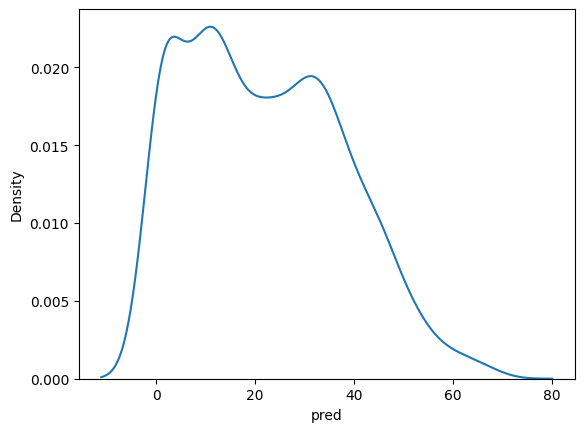

In [16]:
import seaborn as sns

sns.kdeplot(merged, x="pred")

<Axes: xlabel='gt', ylabel='Density'>

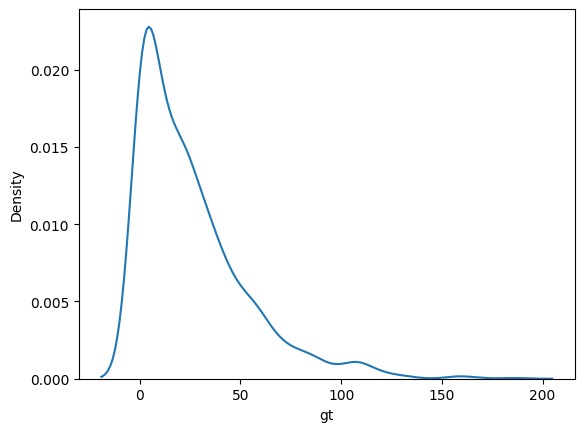

In [17]:
sns.kdeplot(merged, x="gt")

## Calc Metric on Train Preds

In [18]:
# merged: columns ["sample_id", "pred", "gt"] at minimum

# extract base image_id and target_name from sample_id
tmp = merged.copy()
tmp["image_id"] = tmp["sample_id"].str.split("__").str[0]
tmp["target_name"] = tmp["sample_id"].str.split("__").str[1]

primary = ["Dry_Total_g", "GDM_g", "Dry_Green_g"]

# keep only primary targets (metric derives dead/clover)
tmp = tmp[tmp["target_name"].isin(primary)]

# pivot to wide: separate pred/gt tables then merge
pred_w = tmp.pivot(index="image_id", columns="target_name", values="pred")
gt_w   = tmp.pivot(index="image_id", columns="target_name", values="gt")

wide = pred_w.add_prefix("pred_").join(gt_w.add_prefix("gt_"))

# drop rows missing any required value
wide = wide.dropna(subset=[
    "pred_Dry_Total_g","pred_GDM_g","pred_Dry_Green_g",
    "gt_Dry_Total_g","gt_GDM_g","gt_Dry_Green_g"
])

wide.head()


target_name,pred_Dry_Green_g,pred_Dry_Total_g,pred_GDM_g,gt_Dry_Green_g,gt_Dry_Total_g,gt_GDM_g
image_id,,,,,,
ID1011485656,25.203125,48.635418,27.395834,16.2751,48.2735,16.2750
ID1012260530,18.635416,28.328125,24.802084,7.6000,7.6000,7.6000
ID1025234388,0.003252,27.057291,17.062500,0.0000,6.0500,6.0500
ID1028611175,31.031250,52.250000,31.546875,24.2376,55.2079,24.2376
ID1035947949,13.492188,32.208332,15.541667,10.5261,34.1844,10.9605


In [19]:
from src.models.metrics import CompetitionMetric

metric = CompetitionMetric()

pred_total = torch.tensor(wide["pred_Dry_Total_g"].values, dtype=torch.float32)
pred_gdm   = torch.tensor(wide["pred_GDM_g"].values, dtype=torch.float32)
pred_green = torch.tensor(wide["pred_Dry_Green_g"].values, dtype=torch.float32)

y_total = torch.tensor(wide["gt_Dry_Total_g"].values, dtype=torch.float32)
y_gdm   = torch.tensor(wide["gt_GDM_g"].values, dtype=torch.float32)
y_green = torch.tensor(wide["gt_Dry_Green_g"].values, dtype=torch.float32)

global_r2, scores = metric(
    pred_total=pred_total,
    pred_gdm=pred_gdm,
    pred_green=pred_green,
    y_total=y_total,
    y_gdm=y_gdm,
    y_green=y_green,
)

print("Global competition score:", scores["score"])
print(scores)


Global competition score: 0.5282371044158936
{'score': 0.5282371044158936, 'r2_total': 0.35624927282333374, 'r2_gdm': 0.3863571882247925, 'r2_green': 0.48155301809310913, 'r2_dead': 0.25687175989151, 'r2_clover': 0.6087344884872437}


## Predict on Val

In [20]:
# convert wide to long (FIXED)

targets = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

df_long_val = (
    val_fold.melt(
        id_vars=[c for c in val_fold.columns if c not in targets],
        value_vars=targets,
        var_name="target_name",   # <-- FIX: expected by Predictor
        value_name="target",      # <-- numeric value
    )
    .assign(
        sample_id=lambda d: d["image_id"].astype(str) + "__" + d["target_name"]
    )
    .sort_values(["image_id", "target_name"], kind="stable")
    .reset_index(drop=True)
)

# Optional: keep only what submission / inference actually needs
df_long_val = df_long_val[[
    "sample_id",
    "image_path",
    "target_name",
    "target",          # keep for train; for test can be NaN
]]
df_long_val


,sample_id,image_path,target_name,target
0,ID1062837331__Dry_Clover_g,train/ID1062837331.jpg,Dry_Clover_g,19.9800
1,ID1062837331__Dry_Dead_g,train/ID1062837331.jpg,Dry_Dead_g,3.9623
2,ID1062837331__Dry_Green_g,train/ID1062837331.jpg,Dry_Green_g,35.4077
3,ID1062837331__Dry_Total_g,train/ID1062837331.jpg,Dry_Total_g,59.3500
4,ID1062837331__GDM_g,train/ID1062837331.jpg,GDM_g,55.3877
...,...,...,...,...
365,ID963903358__Dry_Clover_g,train/ID963903358.jpg,Dry_Clover_g,0.0000
366,ID963903358__Dry_Dead_g,train/ID963903358.jpg,Dry_Dead_g,29.9634
367,ID963903358__Dry_Green_g,train/ID963903358.jpg,Dry_Green_g,13.8293
368,ID963903358__Dry_Total_g,train/ID963903358.jpg,Dry_Total_g,43.7927


In [21]:
# Load test data
print(f"\n[2/4] Loading test data...")
test_long_df = df_long_val
test_unique_df = val_fold
print(f"✓ Found {len(test_unique_df)} unique test images")

models = [model]
stream_mode = get_stream_mode(cfg.model.model_type)
device = DEVICE

# Create predictor
predictor = Predictor(
    models=models,
    stream_mode=stream_mode,
    device=device,
    use_amp=cfg.inference.use_amp,
    use_tta=cfg.inference.use_tta,
)

# Predict
print(f"\n[3/4] Running inference (TTA={cfg.inference.use_tta})...")
predictions = predictor.predict_with_tta(
    test_df=test_unique_df,
    image_dir=cfg.data.test_image_dir,
    img_size=cfg.data.img_size,
    batch_size=cfg.inference.batch_size,
    num_workers=cfg.inference.num_workers,
)

# Create submission
print(f"\n[4/4] Creating submission...")
submission_val = predictor.create_submission(
    predictions=predictions,
    test_long_df=test_long_df,
    test_unique_df=test_unique_df,
    output_path=cfg.inference.submission_file,
)


[2/4] Loading test data...
✓ Found 74 unique test images

[3/4] Running inference (TTA=True)...
TTA View 1/3


Predicting:   0%|          | 0/19 [00:00<?, ?it/s]/home/ib/CSIRO-Image2BiomassPrediction/notebooks/../src/inference/predictor.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 19/19 [00:01<00:00, 10.06it/s]


TTA View 2/3


Predicting: 100%|██████████| 19/19 [00:01<00:00, 10.15it/s]


TTA View 3/3


Predicting: 100%|██████████| 19/19 [00:01<00:00, 10.03it/s]


[4/4] Creating submission...
✓ Submission saved to submission.csv
                    sample_id     target
0  ID1062837331__Dry_Clover_g  25.174034
1    ID1062837331__Dry_Dead_g   7.281250
2   ID1062837331__Dry_Green_g   7.721798
3   ID1062837331__Dry_Total_g  40.177082
4         ID1062837331__GDM_g  32.895832


In [22]:
# submission: sample_id, target  (pred)
# long_df:    sample_id, target  (gt)

pred_df_val = submission_val.rename(columns={"target": "pred"})
gt_df_val   = df_long_val.rename(columns={"target": "gt"})

merged_val = pred_df_val.merge(gt_df_val, on="sample_id", how="left")

merged_val[["sample_id", "pred", "gt"]].head(20)


,sample_id,pred,gt
0,ID1062837331__Dry_Clover_g,25.174034,19.9800
1,ID1062837331__Dry_Dead_g,7.281250,3.9623
2,ID1062837331__Dry_Green_g,7.721798,35.4077
3,ID1062837331__Dry_Total_g,40.177082,59.3500
4,ID1062837331__GDM_g,32.895832,55.3877
5,ID1078930021__Dry_Clover_g,5.000000,0.0000
6,ID1078930021__Dry_Dead_g,6.364583,5.0189
7,ID1078930021__Dry_Green_g,15.432292,32.9811
8,ID1078930021__Dry_Total_g,26.796875,38.0000
9,ID1078930021__GDM_g,20.432291,32.9811


<Axes: xlabel='pred', ylabel='Density'>

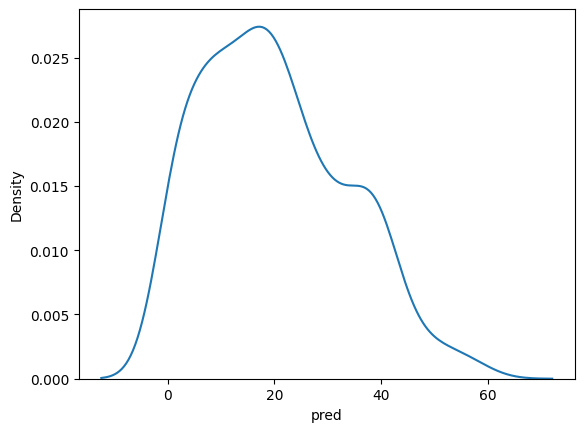

In [29]:
sns.kdeplot(merged_val, x="pred")

<Axes: xlabel='gt', ylabel='Density'>

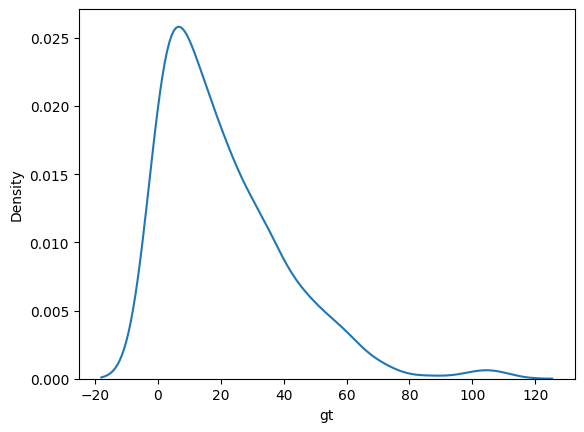

In [28]:
sns.kdeplot(merged_val, x="gt")

In [23]:
# merged: columns ["sample_id", "pred", "gt"] at minimum

# extract base image_id and target_name from sample_id
tmp = merged_val.copy()
tmp["image_id"] = tmp["sample_id"].str.split("__").str[0]
tmp["target_name"] = tmp["sample_id"].str.split("__").str[1]

primary = ["Dry_Total_g", "GDM_g", "Dry_Green_g"]

# keep only primary targets (metric derives dead/clover)
tmp = tmp[tmp["target_name"].isin(primary)]

# pivot to wide: separate pred/gt tables then merge
pred_w = tmp.pivot(index="image_id", columns="target_name", values="pred")
gt_w   = tmp.pivot(index="image_id", columns="target_name", values="gt")

wide = pred_w.add_prefix("pred_").join(gt_w.add_prefix("gt_"))

# drop rows missing any required value
wide = wide.dropna(subset=[
    "pred_Dry_Total_g","pred_GDM_g","pred_Dry_Green_g",
    "gt_Dry_Total_g","gt_GDM_g","gt_Dry_Green_g"
])

wide.head()


target_name,pred_Dry_Green_g,pred_Dry_Total_g,pred_GDM_g,gt_Dry_Green_g,gt_Dry_Total_g,gt_GDM_g
image_id,,,,,,
ID1062837331,7.721798,40.177082,32.895832,35.4077,59.3500,55.3877
ID1078930021,15.432292,26.796875,20.432291,32.9811,38.0000,32.9811
ID1139918758,7.198683,37.645832,29.729166,0.0000,58.3400,58.3400
ID1148666289,28.437500,46.937500,33.864582,21.4846,39.9000,25.5769
ID1176292407,16.000000,35.791668,17.286459,9.0220,25.8893,9.1528


In [24]:
from src.models.metrics import CompetitionMetric

metric = CompetitionMetric()

pred_total = torch.tensor(wide["pred_Dry_Total_g"].values, dtype=torch.float32)
pred_gdm   = torch.tensor(wide["pred_GDM_g"].values, dtype=torch.float32)
pred_green = torch.tensor(wide["pred_Dry_Green_g"].values, dtype=torch.float32)

y_total = torch.tensor(wide["gt_Dry_Total_g"].values, dtype=torch.float32)
y_gdm   = torch.tensor(wide["gt_GDM_g"].values, dtype=torch.float32)
y_green = torch.tensor(wide["gt_Dry_Green_g"].values, dtype=torch.float32)

global_r2, scores = metric(
    pred_total=pred_total,
    pred_gdm=pred_gdm,
    pred_green=pred_green,
    y_total=y_total,
    y_gdm=y_gdm,
    y_green=y_green,
)

print("Global competition score:", scores["score"])
print(scores)


Global competition score: 0.4859488010406494
{'score': 0.4859488010406494, 'r2_total': 0.292008638381958, 'r2_gdm': 0.3078232407569885, 'r2_green': -0.12873637676239014, 'r2_dead': 0.4544838070869446, 'r2_clover': 0.39948534965515137}


## Test img pred

In [25]:
# Load test data
print(f"\n[2/4] Loading test data...")
test_long_df = pd.read_csv(cfg.data.test_csv)
test_unique_df = test_long_df.drop_duplicates(subset=["image_path"]).reset_index(drop=True)
print(f"✓ Found {len(test_unique_df)} unique test images")


[2/4] Loading test data...
✓ Found 1 unique test images


In [34]:
cfg.data.test_image_dir = '/home/ib/CSIRO-Image2BiomassPrediction/data/csiro-biomass/test'
cfg.inference.use_tta = True    
cfg.inference.use_amp = True

In [35]:
# Create predictor
predictor = Predictor(
    models=models,
    stream_mode=stream_mode,
    device=device,
    use_amp=cfg.inference.use_amp,
    use_tta=cfg.inference.use_tta,
)

# Predict
print(f"\n[3/4] Running inference (TTA={cfg.inference.use_tta})...")
predictions = predictor.predict_with_tta(
    test_df=test_unique_df,
    image_dir=cfg.data.test_image_dir,
    img_size=cfg.data.img_size,
    batch_size=cfg.inference.batch_size,
    num_workers=cfg.inference.num_workers,
)

# Create submission
print(f"\n[4/4] Creating submission...")
submission = predictor.create_submission(
    predictions=predictions,
    test_long_df=test_long_df,
    test_unique_df=test_unique_df,
    output_path=cfg.inference.submission_file,
)

print("\n✓ Inference complete!")


[3/4] Running inference (TTA=True)...
TTA View 1/3


Predicting:   0%|          | 0/1 [00:00<?, ?it/s]/home/ib/CSIRO-Image2BiomassPrediction/notebooks/../src/inference/predictor.py:75: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Predicting: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


TTA View 2/3


Predicting: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


TTA View 3/3


Predicting: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


[4/4] Creating submission...
✓ Submission saved to submission.csv
                    sample_id     target
0  ID1001187975__Dry_Clover_g   0.000000
1    ID1001187975__Dry_Dead_g  21.656250
2   ID1001187975__Dry_Green_g  34.354168
3   ID1001187975__Dry_Total_g  55.218750
4         ID1001187975__GDM_g  33.562500

✓ Inference complete!
